In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='0.7'
os.environ['XLA_FLAGS']='--xla_gpu_strict_conv_algorithm_picker=false'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from mazes_data import MazeDataset, prepare_maze_loader
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
from models import RecurModel
import optax
from functools import partial
import equinox as eqx

In [4]:
DATA_ROOT = "data"
ds = MazeDataset(DATA_ROOT, train=True, size=9, download=False)

Loading mazes of size 9 x 9.


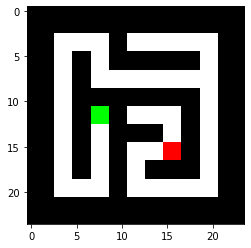

In [5]:
plt.imshow(ds[0][0].transpose(1, 2, 0))

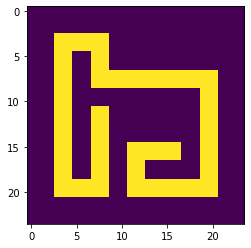

In [6]:
plt.imshow(ds[0][1])

In [7]:
from train import train_epoch, eval_model, train_step, create_train_state, loss_fn

In [8]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

In [9]:
learning_rate = 0.0001
momentum = 0.9

In [10]:
state, tx,static = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [11]:
# static_loss_fn = lambda *args: loss_fn(static, *args)
static_loss_fn = loss_fn


In [12]:
batch = (jax.random.normal(rng, shape=(50, 3, 24, 24)), jax.random.normal(rng, shape=(50, 24, 24)))

In [13]:
%timeit train_step(tx, static_loss_fn, state, batch)

822 µs ± 162 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
train_data = MazeDataset(DATA_ROOT, train=True, size=9, download=True)
train_ds = (train_data.inputs, train_data.targets)

Files already downloaded and verified
Loading mazes of size 9 x 9.


In [15]:
# state = train_epoch(tx, static_loss_fn, state, train_ds, 50, 2, jax.random.PRNGKey(0))

In [16]:
num_epochs = 10
batch_size = 100

In [17]:
import time

In [18]:
key = rng

In [19]:
for epoch in range(1, num_epochs + 1):
  # Run an optimization step over a training batch
  start_time = time.time()
  key, skey = jax.random.split(key)
  state = train_epoch(tx, static_loss_fn, state, train_ds, 50, 2, key)
  epoch_time = time.time() - start_time
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))

train epoch: 2, loss: 0.3124, accuracy: 0.00
Epoch 1 in 22.75 sec


train epoch: 2, loss: 0.2815, accuracy: 0.00
Epoch 2 in 20.05 sec


train epoch: 2, loss: 0.2806, accuracy: 0.00
Epoch 3 in 20.30 sec


train epoch: 2, loss: 0.2804, accuracy: 0.00
Epoch 4 in 21.02 sec


train epoch: 2, loss: 0.2802, accuracy: 0.00
Epoch 5 in 21.05 sec


train epoch: 2, loss: 0.2801, accuracy: 0.00
Epoch 6 in 20.87 sec


train epoch: 2, loss: 0.2800, accuracy: 0.00
Epoch 7 in 20.84 sec


train epoch: 2, loss: 0.2800, accuracy: 0.00
Epoch 8 in 21.07 sec


train epoch: 2, loss: 0.2800, accuracy: 0.00
Epoch 9 in 20.97 sec


train epoch: 2, loss: 0.2799, accuracy: 0.00
Epoch 10 in 20.86 sec


In [24]:
param_count = np.sum(x.size for x in jax.tree_leaves(state[0]))

/tmp/ipykernel_77244/2600573195.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  param_count = np.sum(x.size for x in jax.tree_leaves(state[0]))


In [25]:
param_count

632520

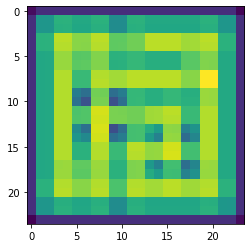

In [25]:
plt.imshow(net(ds[0][0])[0])

In [26]:
accuracy(net(ds[0][0])[0], ds[0][1])

DeviceArray(0.7361111, dtype=float32)

In [30]:
logits = net(ds[0][0])[0] > 0

In [31]:
(logits == ds[0][1]).sum()

DeviceArray(424, dtype=int32)